In [ ]:
# Mount Google Drive (if your data is stored there; skip this if using local files)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# Set the working directory (update the path based on your environment)
# If using Google Colab with Google Drive, specify the correct path; otherwise, use a local path.
os.chdir('/content/drive/MyDrive/Project_VTTI')  # Example for Google Colab
# os.chdir('/path/to/your/local/directory')  # Uncomment and replace for local usage

In [ ]:
import pandas as pd
import os  # Import necessary libraries

# Function to aggregate all CSV files from a given directory into a single DataFrame
def aggregate_csvs(directory_path):
    dataframes = []

    # Traverse the directory and subdirectories to find CSV files
    for subdir, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.csv'):
                filepath = os.path.join(subdir, file)
                df = pd.read_csv(filepath)
                dataframes.append(df)

    # Concatenate all DataFrames into one
    aggregated_df = pd.concat(dataframes, ignore_index=True)
    return aggregated_df

# Aggregate data for identified and unknown datasets
identified_data = aggregate_csvs('Identified_Classifier')  # Folder for identified (split) datasets
unknown_data = aggregate_csvs('Unknown_Classifier')        # Folder for unknown (split) datasets

# Function to extract important features from the dataset
def extract_important_features(df):
    window_steering = 10 * 1000  # 10-second window for steering features
    window_distance = 1 * 1000   # 1-second window for lane distance features

    # Steering features
    df['steering_stability'] = df['vtti.steering_wheel_position'].rolling(window=window_steering).std()

    # Pedal features
    df['brake_duration'] = df.groupby((df['vtti.pedal_brake_state'] != df['vtti.pedal_brake_state'].shift()).cumsum()).cumcount() * df['vtti.pedal_brake_state']
    df['brake_event'] = df['vtti.pedal_brake_state'].diff().apply(lambda x: 1 if x == 1 else 0)
    df['brake_frequency'] = df['brake_event'].rolling(window=window_steering).sum()

    # Lateral position features
    df['avg_abs_distance_from_center'] = df['vtti.lane_distance_off_center'].abs().rolling(window=window_distance).mean()
    df['lateral_velocity'] = df['vtti.lane_distance_off_center'].diff()
    df['lateral_acceleration'] = df['lateral_velocity'].diff()

    return df

# Apply feature extraction to both datasets
identified_data = extract_important_features(identified_data)
unknown_data = extract_important_features(unknown_data)

# Define significant columns to keep in the final analysis
significant_columns = [
    'lateral_velocity', 'brake_frequency',
    'avg_abs_distance_from_center', 'lateral_acceleration'
]

# Filter the DataFrames to include only the significant features
identified_data = identified_data[significant_columns]
unknown_data = unknown_data[significant_columns]



In [ ]:
# Drop rows with any missing values in both datasets
identified_data.dropna(inplace=True)
unknown_data.dropna(inplace=True)


In [ ]:
# Check the shape of both datasets to ensure they are healthy
print("Identified Data Shape:", identified_data.shape)
print("Unknown Data Shape:", unknown_data.shape)

(1022486, 4)
(1069361, 4)


In [ ]:
# Check for null values in the identified dataset before proceeding
print(identified_data[['lateral_velocity', 'brake_frequency', 
                       'avg_abs_distance_from_center', 'lateral_acceleration']].isna().sum())

lateral_velocity                0
brake_frequency                 0
avg_abs_distance_from_center    0
lateral_acceleration            0
dtype: int64


In [ ]:
# Check for null values in the unknown dataset before proceeding
print(unknown_data[['lateral_velocity', 'brake_frequency', 
                    'avg_abs_distance_from_center', 'lateral_acceleration']].isna().sum())

lateral_velocity                0
brake_frequency                 0
avg_abs_distance_from_center    0
lateral_acceleration            0
dtype: int64


In [ ]:
# Preview the first 100 rows of the identified dataset to check for a healthy shape
print(identified_data.head(100))

       lateral_velocity  brake_frequency  avg_abs_distance_from_center  \
15038          0.000000             58.0                    124.497663   
15039          0.000000             58.0                    124.490494   
15040          0.000000             58.0                    124.488096   
15041          0.000000             58.0                    124.485699   
15042          0.000000             58.0                    124.483301   
...                 ...              ...                           ...   
15133          0.000000             58.0                    118.997795   
15134          0.000000             58.0                    118.890905   
15135         73.443410             58.0                    118.917091   
15136         38.161072             58.0                    118.922848   
15137         -0.677319             58.0                    118.927674   

       lateral_acceleration  
15038              0.000000  
15039              0.000000  
15040              0.

In [ ]:
# Preview the first 100,000 rows of the unknown dataset to check for a healthy shape
print(unknown_data.head(100000))

        lateral_velocity  brake_frequency  avg_abs_distance_from_center  \
10433           0.000000              1.0                      8.499999   
10434           0.000000              1.0                      8.499999   
10435           0.000000              1.0                      8.499999   
10436           0.000000              1.0                      8.499999   
10437           0.000000              1.0                      8.499999   
...                  ...              ...                           ...   
294583          3.894670              0.0                     30.364727   
294584          4.233342              0.0                     30.392145   
294585         -1.550535              0.0                     30.418520   
294586          9.001236              0.0                     30.452966   
294587         11.937995              0.0                     30.500365   

        lateral_acceleration  
10433               0.000000  
10434               0.000000  
10435 

In [ ]:
# Random Forest Model Preparation
import joblib
from sklearn.model_selection import train_test_split

# Avoid unnecessary warnings by copying the datasets
identified_data = identified_data.copy()
unknown_data = unknown_data.copy()
# Create target labels for identified (1) and unknown (0) datasets
identified_data['target'] = 1
unknown_data['target'] = 0
# Combine the datasets
combined_data = pd.concat([identified_data, unknown_data], ignore_index=True)
# Handle missing values by filling with 0
combined_data.fillna(0, inplace=True)
# Split the data into features (X) and target (y)
X = combined_data.drop('target', axis=1)
y = combined_data['target']
# Train-test split (80% training, 20% testing)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)
# Save the test data for future use
joblib.dump(X_test_rf, 'X_test_rf.pkl')
joblib.dump(y_test_rf, 'y_test_rf.pkl')

['y_test_rf.pkl']

In [ ]:
# Training the Random Forest model using 1 million rows per class (identified and unknown)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=5)
# Train the model
rf_model.fit(X_train_rf, y_train_rf)
# Make predictions on training and test data
y_pred_train_rf = rf_model.predict(X_train_rf)
y_pred_test_rf = rf_model.predict(X_test_rf)
# Evaluate the model performance
print("Training Accuracy:", accuracy_score(y_train_rf, y_pred_train_rf))
print("Test Accuracy:", accuracy_score(y_test_rf, y_pred_test_rf))
# Display the classification report for test data
print("\nClassification Report (1 = Identified, 0 = Unknown):\n", classification_report(y_test_rf, y_pred_test_rf))

Training Accuracy is: 0.9936832116605128
Test Accuracy is: 0.8201448478619404

Classification Report for Test Data:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83    213831
           1       0.83      0.80      0.81    204539

    accuracy                           0.82    418370
   macro avg       0.82      0.82      0.82    418370
weighted avg       0.82      0.82      0.82    418370



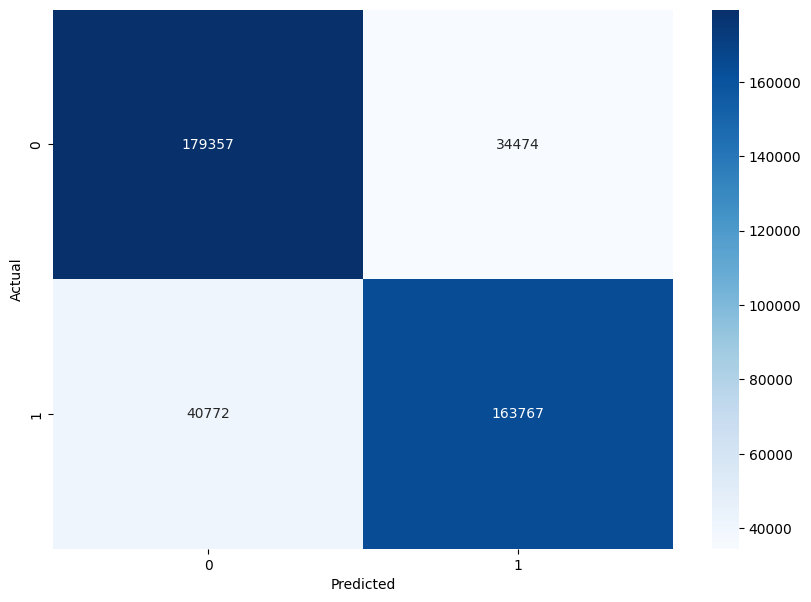

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test_rf, y_pred_test_rf)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()


In [ ]:
# Calculate feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
# Display the feature ranking
print("Feature Ranking:")
for i in range(X.shape[1]):
    print(f"{i + 1}. Feature: {features[indices[i]]} (Importance Score: {importances[indices[i]]:.6f})")

Features ranking:
1. feature avg_abs_distance_from_center (0.463093)
2. feature brake_frequency (0.237588)
3. feature lateral_acceleration (0.151131)
4. feature lateral_velocity (0.148187)


In [ ]:
import joblib  # Import joblib for model saving
# Save the trained Random Forest model to a file (only run if you want to save the model)
joblib.dump(rf_model, 'rf_model.pkl')

['sf_final_model.pkl']

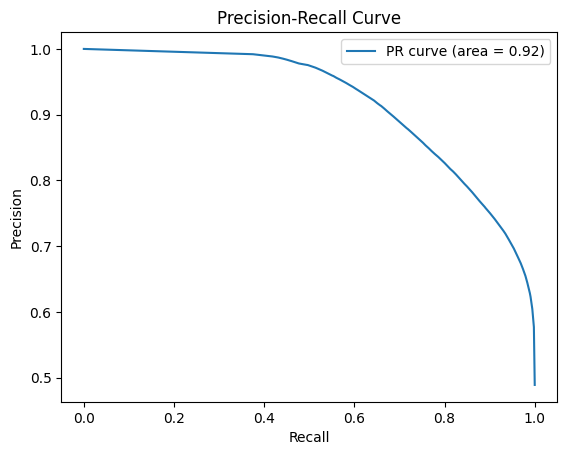

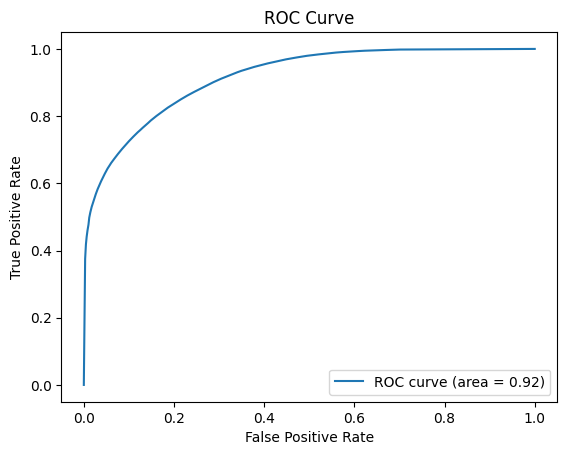

Log Loss: 0.4343598625017414
Cohen's Kappa is: 0.6398712375846103
Matthews Correlation Coefficient is: 0.6401621168382002


In [ ]:
import joblib  # Re-import in case the notebook was not run sequentially
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    average_precision_score, log_loss,
    cohen_kappa_score, matthews_corrcoef
)
# Load the trained Random Forest model (if not already loaded)
rf_model = joblib.load('rf_model.pkl')
# Ensure that X_test and y_test are loaded; rerun previous cells if needed
y_prob_rf = rf_model.predict_proba(X_test_rf)[:, 1]
y_pred_rf = rf_model.predict(X_test_rf)
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_rf, y_prob_rf)
average_precision = average_precision_score(y_test_rf, y_prob_rf)
plt.figure()
plt.plot(recall, precision, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_rf, y_prob_rf)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()
# Log Loss
print(f"Log Loss: {log_loss(y_test_rf, y_prob_rf):.4f}")
# Cohen's Kappa Score
kappa = cohen_kappa_score(y_test_rf, y_pred_rf)
print(f"Cohen's Kappa: {kappa:.4f}")
# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test_rf, y_pred_rf)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
